### 0. Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import tqdm
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
from gan import Generator, Discriminator

### 1. Setup

In [4]:
!pip install ipywidgets
content_path = './notebooks'
data_path = './data/'

In [8]:
mean = torch.Tensor([0.5, 0.5, 0.5])
std = torch.Tensor([0.5, 0.5, 0.5])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):

    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path + '/GAN'):
    os.makedirs(content_path + '/GAN')

GPU = False
if GPU:
    device = torch.device("mps"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("mps")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using mps


### 2. Load data

In [9]:
batch_size = 128
image_size = 32

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


### 3. Define hyperparameters and initialise models

In [11]:
num_epochs = 5
learning_rate = 0.0002
learning_rate_G = 0.0002
learning_rate_D = 0.0001
latent_vector_size = 150

generator_hyper_params = {
    "latent_vector_size": latent_vector_size,
    "gen_feature_map": 150,
}

discriminator_hyper_params = {
    "disc_feature_map": 64,
}


In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def init_models(generator_hyper_params, disc_hyper_params):
    use_weights_init = True

    model_G = Generator(generator_hyper_params=generator_hyper_params).to(device)
    if use_weights_init:
        model_G.apply(weights_init)
    params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
    print("Total number of parameters in Generator is: {}".format(params_G))
    print(model_G)
    print('\n')

    model_D = Discriminator(discriminator_hyper_params=disc_hyper_params).to(device)
    if use_weights_init:
        model_D.apply(weights_init)
    params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
    print(
        "Total number of parameters in Discriminator is: {}".format(params_D))
    print(model_D)
    print('\n')

    print("Total number of parameters is: {}".format(params_G + params_D))
    return model_G, model_D, params_G, params_D

### 4. Train the model

***Define the loss and initialise optimisers***
NB we are defining a model with historical averaging, hence the 'hist' suffix.

In [13]:
def G_loss_function(y, y_hat):
    loss = nn.BCELoss()
    return loss(y_hat, y)

def D_loss_function(y, y_hat):
    loss = nn.BCELoss()
    return loss(y_hat, y)

def loss_hist(params, params_avg):
    loss = F.mse_loss(params, params_avg)
    return loss

In [14]:
model_G_hist, model_D_hist, params_G_hist, params_D_hist  = init_models(generator_hyper_params=generator_hyper_params,
                                                                        disc_hyper_params=discriminator_hyper_params)
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D_hist.parameters(), lr=learning_rate_D, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G_hist.parameters(), lr=learning_rate_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 0.9
fake_label = 0.1

Total number of parameters in Generator is: 18008550
Generator(
  (conv): Sequential(
    (0): ConvTranspose2d(150, 1200, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1200, 600, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(600, 300, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(300, 150, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(150, 3, kernel_size=(3, 3), stride=

Logging

In [15]:
train_losses_G_hist = []
train_losses_D_hist = []
train_losses_G_all = []
train_losses_D_all = []

Training loop

In [ ]:
for epoch in range(num_epochs):
    param_avg_G = torch.zeros(params_G_hist).to(device)
    param_avg_D = torch.zeros(params_D_hist).to(device)
    n = 0
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        for i, data in enumerate(tepoch):
            train_loss_D = 0
            train_loss_G = 0

            #######################################################################
            #                  ** TRAIN DISCRIMINATOR WITH REAL **
            #######################################################################
            model_D_hist.zero_grad()
            real_cpu = data[0].to(device)
            size = real_cpu.size(0)
            output_real = model_D_hist(real_cpu).view(-1)
            target = torch.full((size,), real_label, dtype=torch.float, device=device)
            errD_real = D_loss_function(target, output_real)
            errD_real.backward()
            D_x = output_real.mean().item()

            #######################################################################
            #                  ** TRAIN DISCRIMINATOR WITH FAKE **
            #######################################################################
            noise = torch.randn(size, latent_vector_size, 1, 1, device=device)
            fake_image = model_G_hist(noise)
            target = target.fill_(fake_label)
            output_fake = model_D_hist(fake_image.detach()).view(-1)

            #######################################################################
            #                          ** UPDATE GRADIENTS **
            #######################################################################
            errD_fake = D_loss_function(target, output_fake)
            errD_fake.backward()

            #######################################################################
            #                          ** PERFORM HISTORICAL AVERAGING **
            #######################################################################
            param_D_current = torch.cat([param.view(-1) for param in model_D_hist.parameters()]).to(device)
            param_avg_D = ( (n*param_avg_D.detach()  + param_D_current.detach()) / (n+1)).to(device)
            errD_hist_avg = loss_hist(param_D_current, param_avg_D)
            errD_hist_avg.backward()
            errD = errD_real + errD_fake + errD_hist_avg
            D_G_z1 = output_fake.mean().item()
            train_loss_D += errD.item()
            optimizerD.step()

            #######################################################################
            #                     ** UPDATE GENERATOR NETWORK **
            #######################################################################
            model_G_hist.zero_grad()
            output = model_D_hist(fake_image).view(-1)
            target = target.fill_(real_label)
            errG_standard = G_loss_function(target, output)
            errG_standard.backward()
            D_G_z2 = output.mean().item()

            #######################################################################
            #            ** PERFORM HISTORICAL AVERAGING ON GENERATOR **
            #######################################################################
            param_G_current = torch.cat([param.view(-1) for param in model_G_hist.parameters()]).to(device)
            param_avg_G = ((n * param_avg_G.detach() + param_G_current.detach())/ (n+1)).to(device)
            errG_avg = loss_hist(param_G_current, param_avg_G)
            errG_avg.backward()
            errG = errG_avg + errG_standard
            train_loss_G += errG.item()
            optimizerG.step()
            train_losses_D_all.append(errD.item())
            train_losses_G_all.append(errG.item())
            n += 1

            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())

    with torch.no_grad():
        fake = model_G_hist(fixed_noise)
        #save_image(denorm(fake.cpu()).float(), content_path + '/GAN/historical_averaging/fake_samples_epoch{epoch}.png')
    train_losses_D_hist.append(train_loss_D)
    train_losses_G_hist.append(train_loss_G)



### 5. Show generator samples

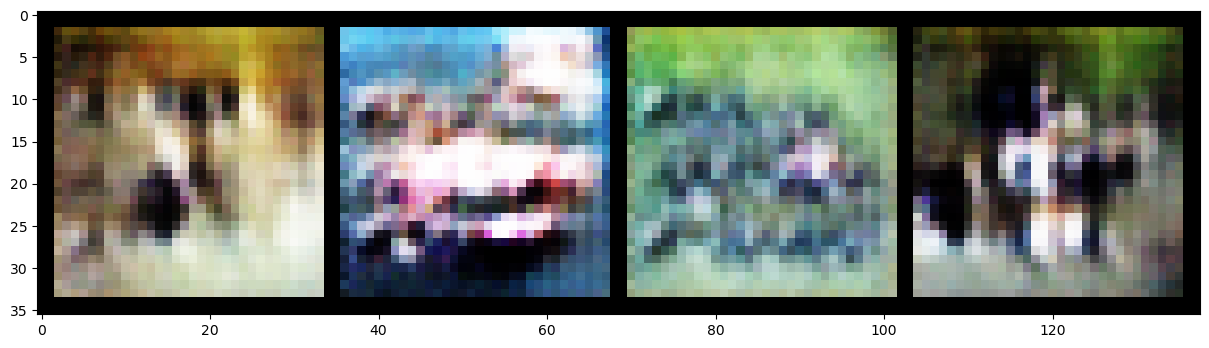

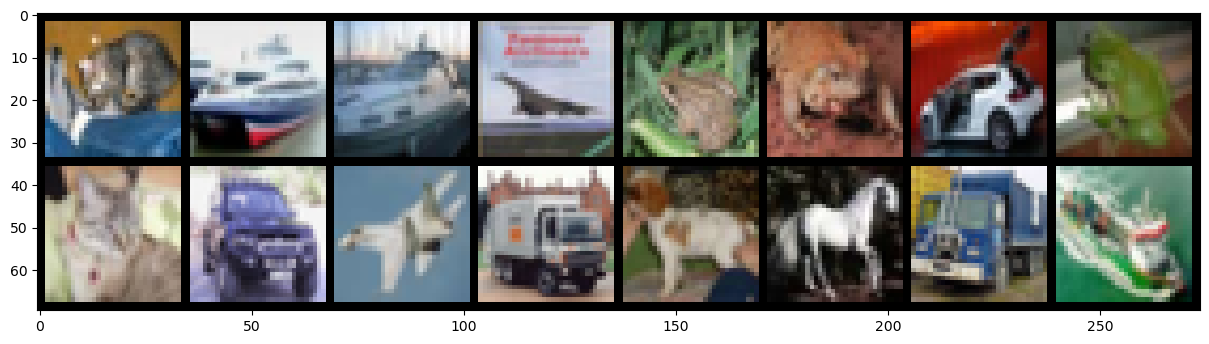

In [29]:
input_noise = torch.randn(4, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    generated = model_G_hist(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False,
                        scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    #save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:16, :, :, :]

img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)